In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
from os import pardir
import sys
import healpy as hp
from scipy import interpolate

In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

from utils import load_spectral_types, main_sequence_cut_r, main_locus

In [3]:
root_data_dir = abspath(join(pardir, "Data"))
data_dir = join(root_data_dir, "Completeness")
comp_path = join(data_dir, "completeness-single.hdf5")

In [4]:
# import mamajek spectral boundaries
df_s = load_spectral_types()
df_s

,SpT,M_J,J-H,H-Ks,J-K
0,O9V,-3.44,-0.164,-0.071,-0.235
1,O9.5V,-3.30,-0.161,-0.069,-0.230
2,B0V,-3.17,-0.159,-0.067,-0.226
3,B0.5V,-2.80,-0.153,-0.063,-0.216
4,B1V,-2.33,-0.148,-0.059,-0.207
...,...,...,...,...,...
95,T6V,15.34,0.100,-0.030,0.070
96,T7V,15.83,0.000,0.000,0.000
97,T7.5V,16.61,0.200,-0.050,0.150
98,T8V,17.30,0.200,-0.050,0.150


In [5]:
comp_raw = vaex.open(comp_path)
comp_raw

#,comp,JK,JK_low,JK_high,J,J_low,J_high
0,0.0,-0.95,-1.0,-0.9,4.109999999999999,4.0,4.22
1,0.0,-0.95,-1.0,-0.9,4.33,4.22,4.44
2,0.0,-0.95,-1.0,-0.9,4.550000000000001,4.44,4.66
3,0.0,-0.95,-1.0,-0.9,4.77,4.66,4.88
4,0.0,-0.95,-1.0,-0.9,4.99,4.88,5.1
...,...,...,...,...,...,...,...
"1,495",0.05531087616556061,1.9500000000000002,1.9000000000000004,2.0,14.01,13.9,14.12
"1,496",0.05500841005665722,1.9500000000000002,1.9000000000000004,2.0,14.23,14.12,14.34
"1,497",0.05556735329510866,1.9500000000000002,1.9000000000000004,2.0,14.45,14.34,14.56
"1,498",0.053377039326001,1.9500000000000002,1.9000000000000004,2.0,14.67,14.56,14.78


In [34]:
J = comp_raw.J.to_numpy()
J = np.unique(J)

eJ = comp_raw.J_low.to_numpy()
eJ = np.unique(eJ)
eJ = np.append(eJ, comp_raw.J_high.to_numpy()[-1])

JK = comp_raw.JK.to_numpy()
JK = np.unique(JK)

eJK = comp_raw.JK_low.to_numpy()
eJK = np.unique(eJK)
eJK = np.append(eJK, comp_raw.JK_high.to_numpy()[-1])

comp = np.zeros((len(J), len(JK)))
for i in range(len(J)):
    comp[i] = comp_raw[comp_raw.J == J[i]].comp.to_numpy()
comp

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.05434282, 0.05517144,
        0.05556735],
       [0.        , 0.        , 0.        , ..., 0.05334468, 0.05303835,
        0.05337704],
       [0.        , 0.        , 0.        , ..., 0.05109583, 0.05054284,
        0.05115379]])

Text(0, 0.5, 'J')

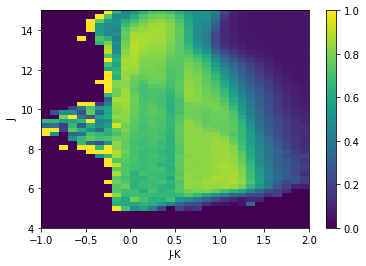

In [7]:
plt.imshow(comp, origin="lower", extent=[eJK[0], eJK[-1], eJ[0], eJ[-1]], aspect="auto")
plt.colorbar()
plt.xlabel("J-K")
plt.ylabel("J")


In [50]:
jk, j = np.meshgrid(JK, J)
comp_interp_ = interpolate.interp2d(jk, j, comp, kind='linear', fill_value=0)
# return 0 if the result is negative
comp_interp = lambda jk, j: np.maximum(comp_interp_(jk, j), 0)

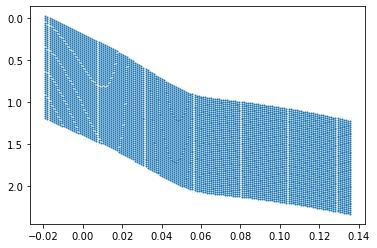

In [53]:
# A star boundaries
JK_lower = (df_s[df_s['SpT'] == 'B9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'A0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'A9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'F0V']['J-K'].to_numpy()[0])/2

JK_unique = np.linspace(JK_lower, JK_upper, 150)
MJ = np.array([])
JK = np.array([])
for jk in JK_unique:
  MJ_lower = main_sequence_cut_r(jk, low=True)
  MJ_upper = main_sequence_cut_r(jk)
  MJ_dummy = np.linspace(MJ_lower, MJ_upper, 50)
  JK_dummy = np.ones_like(MJ_dummy)*jk
  MJ = np.concatenate((MJ, MJ_dummy), axis=0)
  JK = np.concatenate((JK, JK_dummy), axis=0)
plt.scatter(JK, MJ, s=1)
plt.gca().invert_yaxis()

In [60]:
# distance modulus
DMs = np.linspace(0, 17, 200)

In [61]:
comDM = np.zeros_like(DMs)
for j, DM in enumerate(DMs):
  comp_val = np.empty_like(MJ)
  for i, (jk, mj) in enumerate(zip(JK, MJ)):
    comp_val[i] = comp_interp(jk, mj+DM)
  comp_avg = np.mean(comp_val)
  comDM[j] = comp_avg
  print(j, end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

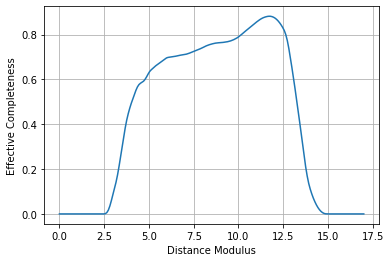

In [62]:
plt.plot(DMs, comDM)
plt.xlabel("Distance Modulus")
plt.ylabel("Effective Completeness")
plt.grid()
plt.show()

In [63]:
df_A_comp = vaex.from_arrays(DM=DMs, comp=comDM)
df_A_comp

#,DM,comp
0,0.0,0.0
1,0.08542713567839195,0.0
2,0.1708542713567839,0.0
3,0.2562814070351759,0.0
4,0.3417085427135678,0.0
...,...,...
195,16.65829145728643,0.0
196,16.74371859296482,0.0
197,16.829145728643216,0.0
198,16.914572864321606,0.0


In [79]:
df_A_comp.export(join(data_dir, "comp-A-2.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.04s =  0.0m =  0.0h
 

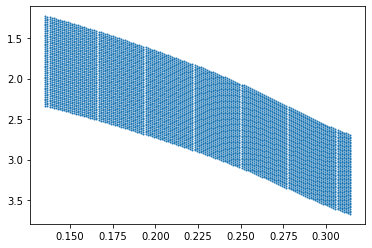

In [64]:
# F star boundaries
JK_lower = (df_s[df_s['SpT'] == 'A9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'F0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'F9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G0V']['J-K'].to_numpy()[0])/2

JK_unique = np.linspace(JK_lower, JK_upper, 150)
MJ = np.array([])
JK = np.array([])
for jk in JK_unique:
  MJ_lower = main_sequence_cut_r(jk, low=True)
  MJ_upper = main_sequence_cut_r(jk)
  MJ_dummy = np.linspace(MJ_lower, MJ_upper, 50)
  JK_dummy = np.ones_like(MJ_dummy)*jk
  MJ = np.concatenate((MJ, MJ_dummy), axis=0)
  JK = np.concatenate((JK, JK_dummy), axis=0)
plt.scatter(JK, MJ, s=1)
plt.gca().invert_yaxis()

In [71]:
# distance modulus
DMs = np.linspace(-1, 17, 200)

In [72]:
comDM = np.zeros_like(DMs)
for j, DM in enumerate(DMs):
  comp_val = np.empty_like(MJ)
  for i, (jk, mj) in enumerate(zip(JK, MJ)):
    comp_val[i] = comp_interp(jk, mj+DM)
  comp_avg = np.mean(comp_val)
  comDM[j] = comp_avg
  print(j, end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

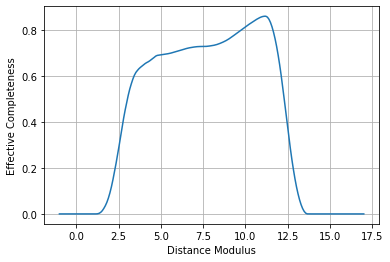

In [73]:
plt.plot(DMs, comDM)
plt.xlabel("Distance Modulus")
plt.ylabel("Effective Completeness")
plt.grid()
plt.show()

In [74]:
df_F_comp = vaex.from_arrays(DM=DMs, comp=comDM)
df_F_comp

#,DM,comp
0,-1.0,0.0
1,-0.9095477386934674,0.0
2,-0.8190954773869347,0.0
3,-0.728643216080402,0.0
4,-0.6381909547738693,0.0
...,...,...
195,16.63819095477387,0.0
196,16.728643216080403,0.0
197,16.819095477386934,0.0
198,16.90954773869347,0.0


In [80]:
df_F_comp.export(join(data_dir, "comp-F-2.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.01s =  0.0m =  0.0h
 

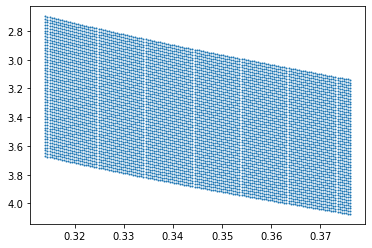

In [75]:
# G star boundaries
JK_lower = (df_s[df_s['SpT'] == 'F9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'G3V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G4V']['J-K'].to_numpy()[0])/2

JK_unique = np.linspace(JK_lower, JK_upper, 150)
MJ = np.array([])
JK = np.array([])
for jk in JK_unique:
  MJ_lower = main_sequence_cut_r(jk, low=True)
  MJ_upper = main_sequence_cut_r(jk)
  MJ_dummy = np.linspace(MJ_lower, MJ_upper, 50)
  JK_dummy = np.ones_like(MJ_dummy)*jk
  MJ = np.concatenate((MJ, MJ_dummy), axis=0)
  JK = np.concatenate((JK, JK_dummy), axis=0)
plt.scatter(JK, MJ, s=1)
plt.gca().invert_yaxis()

In [82]:
# distance modulus
DMs = np.linspace(-2, 15, 200)

In [83]:
comDM = np.zeros_like(DMs)
for j, DM in enumerate(DMs):
  comp_val = np.empty_like(MJ)
  for i, (jk, mj) in enumerate(zip(JK, MJ)):
    comp_val[i] = comp_interp(jk, mj+DM)
  comp_avg = np.mean(comp_val)
  comDM[j] = comp_avg
  print(j, end=" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

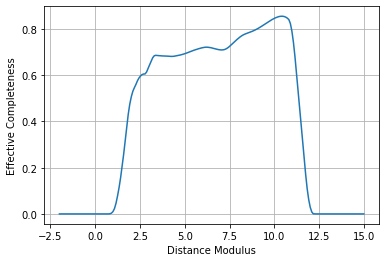

In [84]:
plt.plot(DMs, comDM)
plt.xlabel("Distance Modulus")
plt.ylabel("Effective Completeness")
plt.grid()
plt.show()

In [85]:
df_G_comp = vaex.from_arrays(DM=DMs, comp=comDM)
df_G_comp

#,DM,comp
0,-2.0,0.0
1,-1.914572864321608,0.0
2,-1.829145728643216,0.0
3,-1.7437185929648242,0.0
4,-1.6582914572864322,0.0
...,...,...
195,14.658291457286431,0.0
196,14.743718592964822,0.0
197,14.829145728643216,0.0
198,14.914572864321606,0.0


In [86]:
df_G_comp.export(join(data_dir, "comp-G-2.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.06s =  0.0m =  0.0h
 